# Tracing for Different Types of Runs

### Types of Runs

LangSmith supports many different types of Runs - you can specify what type your Run is in the @traceable decorator. The types of runs are:

- LLM: Invokes an LLM
- Retriever: Retrieves documents from databases or other sources
- Tool: Executes actions with function calls
- Chain: Default type; combines multiple Runs into a larger process
- Prompt: Hydrates a prompt to be used with an LLM
- Parser: Extracts structured data

### Setup

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(override=True)

True

### LLM Runs for Chat Models

LangSmith provides special rendering and processing for LLM traces. In order to make the most of this feature, you must log your LLM traces in a specific format.

For chat-style models, inputs must be a list of messages in OpenAI-compatible format, represented as Python dictionaries or TypeScript object. Each message must contain the key role and content.

The output is accepted in any of the following formats:

- A dictionary/object that contains the key choices with a value that is a list of dictionaries/objects. Each dictionary/object must contain the key message, which maps to a message object with the keys role and content.
- A dictionary/object that contains the key message with a value that is a message object with the keys role and content.
- A tuple/array of two elements, where the first element is the role and the second element is the content.
- A dictionary/object that contains the key role and content.
The input to your function should be named messages.

You can also provide the following metadata fields to help LangSmith identify the model and calculate costs. If using LangChain or OpenAI wrapper, these fields will be automatically populated correctly.
- ls_provider: The provider of the model, eg "openai", "anthropic", etc.
- ls_model_name: The name of the model, eg "gpt-4o-mini", "claude-3-opus-20240307", etc.

In [3]:
from langsmith import traceable

inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "I'd like to book a table for two."},
]

output = {
  "choices": [
      {
          "message": {
              "role": "assistant",
              "content": "Sure, what time would you like to book the table for?"
          }
      }
  ]
}

# output = {
#     "role": "assistant",
#     "content": "Sure, what time would you like to book the table for?"
# }
#
# output = ["assistant", "Sure, what time would you like to book the table for?"]

@traceable(
  # TODO: Add an run_type="llm", and metadata for ls_provider, and ls_model_name
  run_type="llm",
  metadata={
    "ls_provider": "anthropic", 
    "ls_model_name": "claude-35-sonnet"
  }
)
def chat_model(messages: list):
  return output

chat_model(inputs)

{'choices': [{'message': {'role': 'assistant',
    'content': 'Sure, what time would you like to book the table for?'}}]}

# Difference when run_type is mentioned and when its not
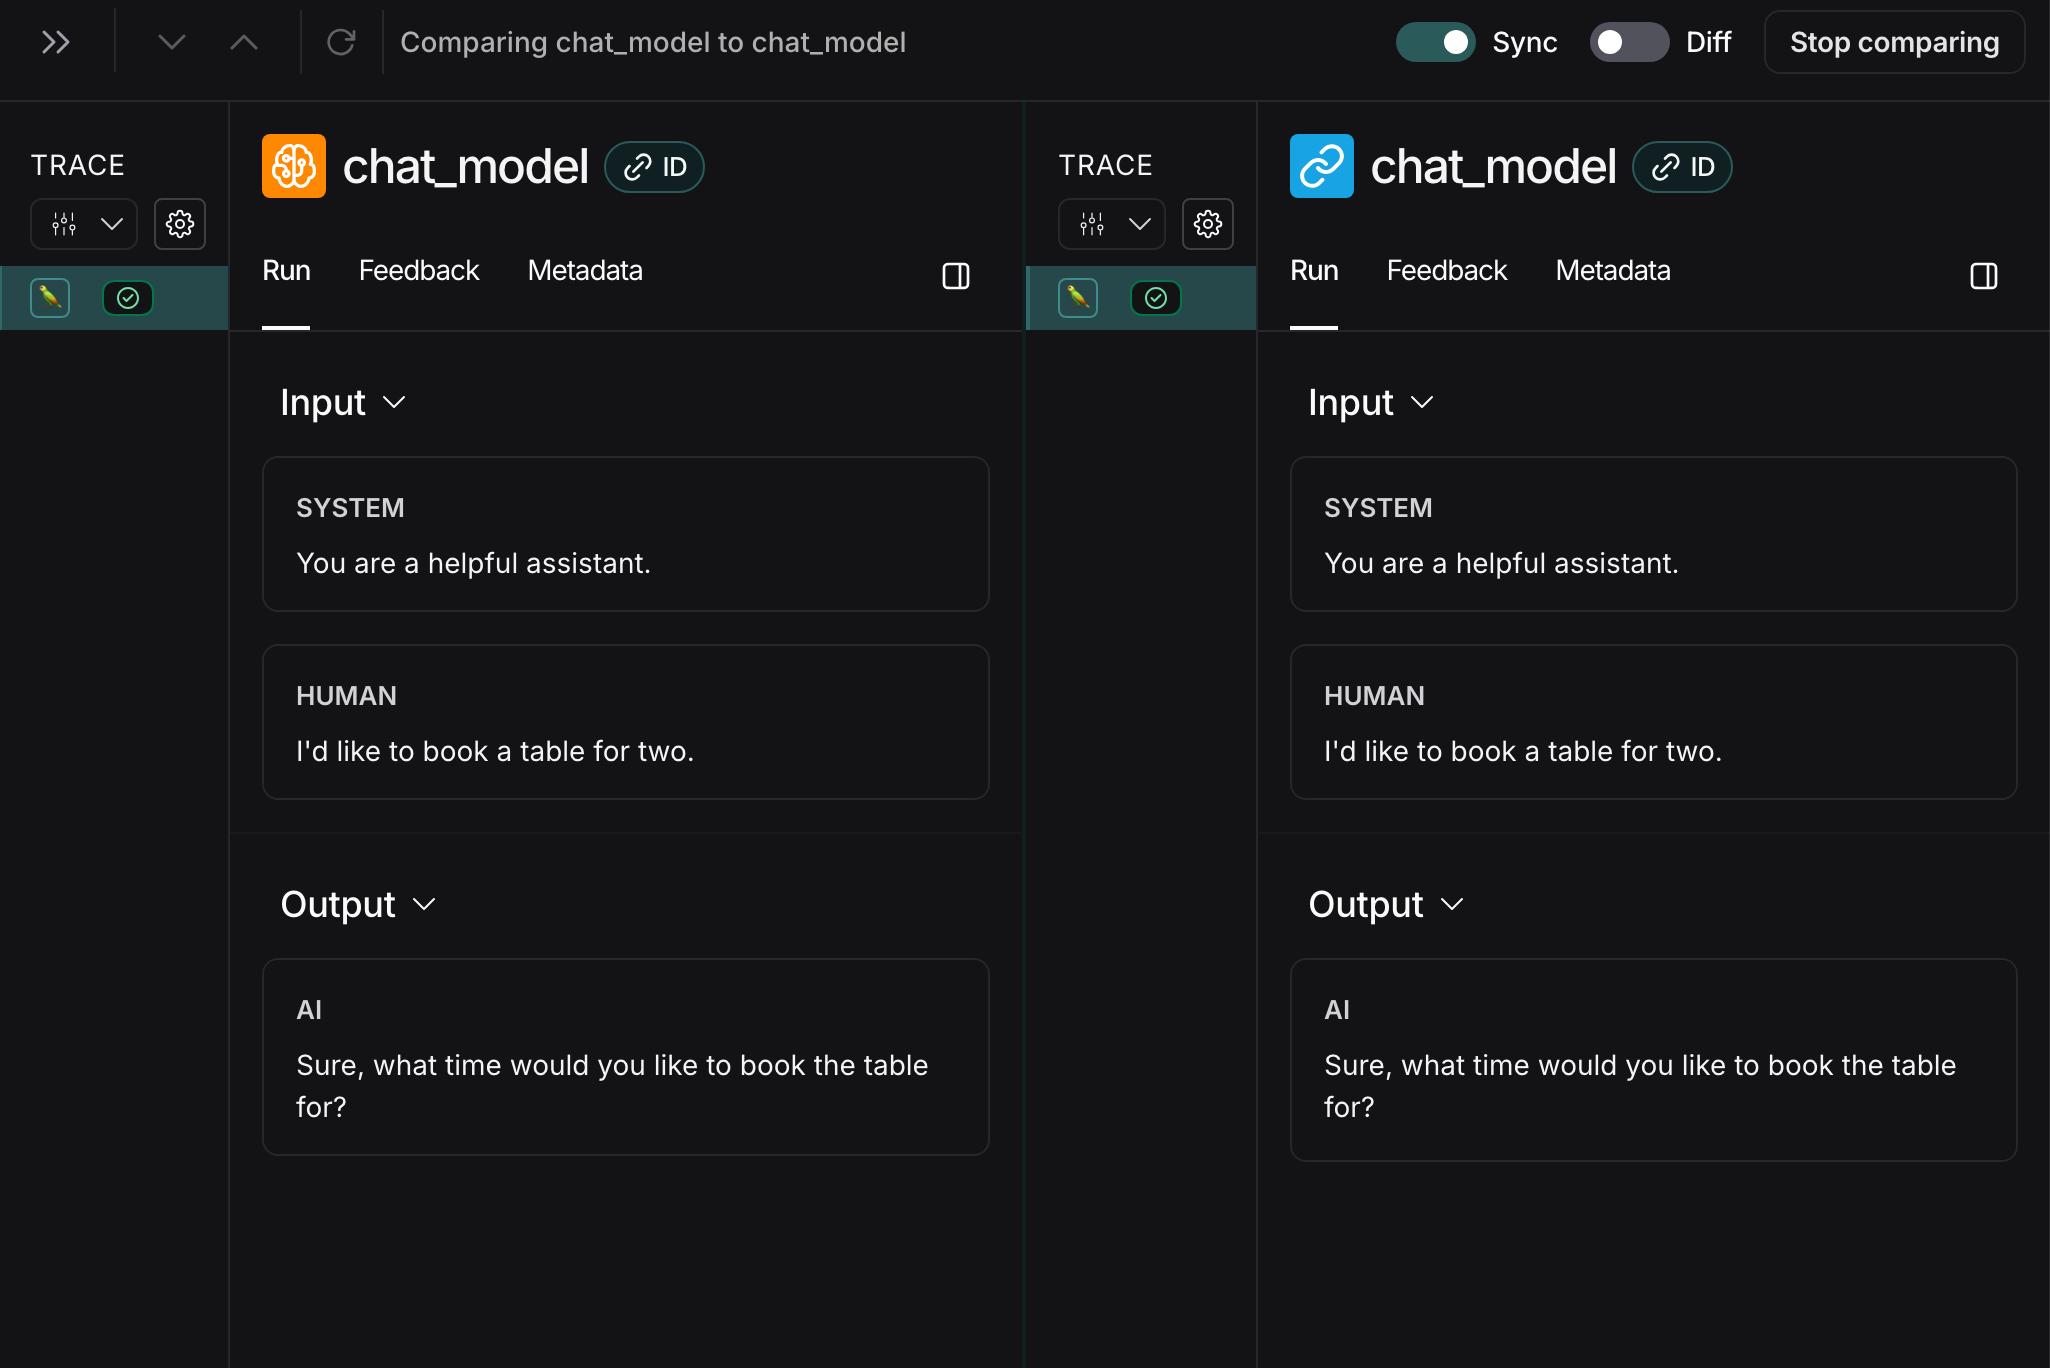

# Playground is accessible when run type is specified as llm
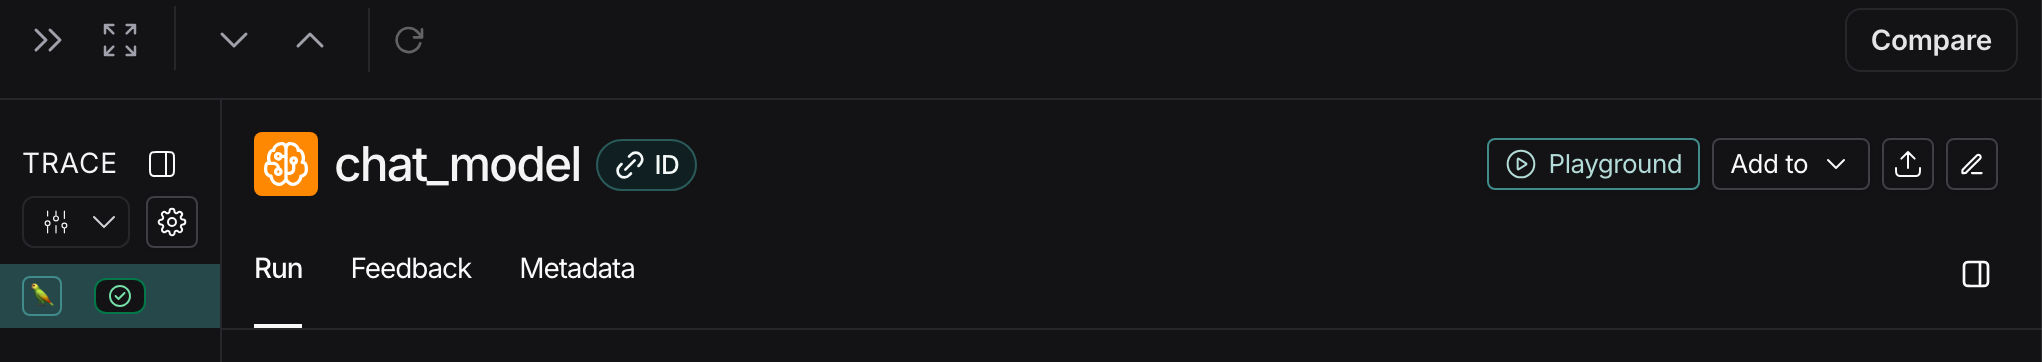

# Metadata appeared in the way we entered it
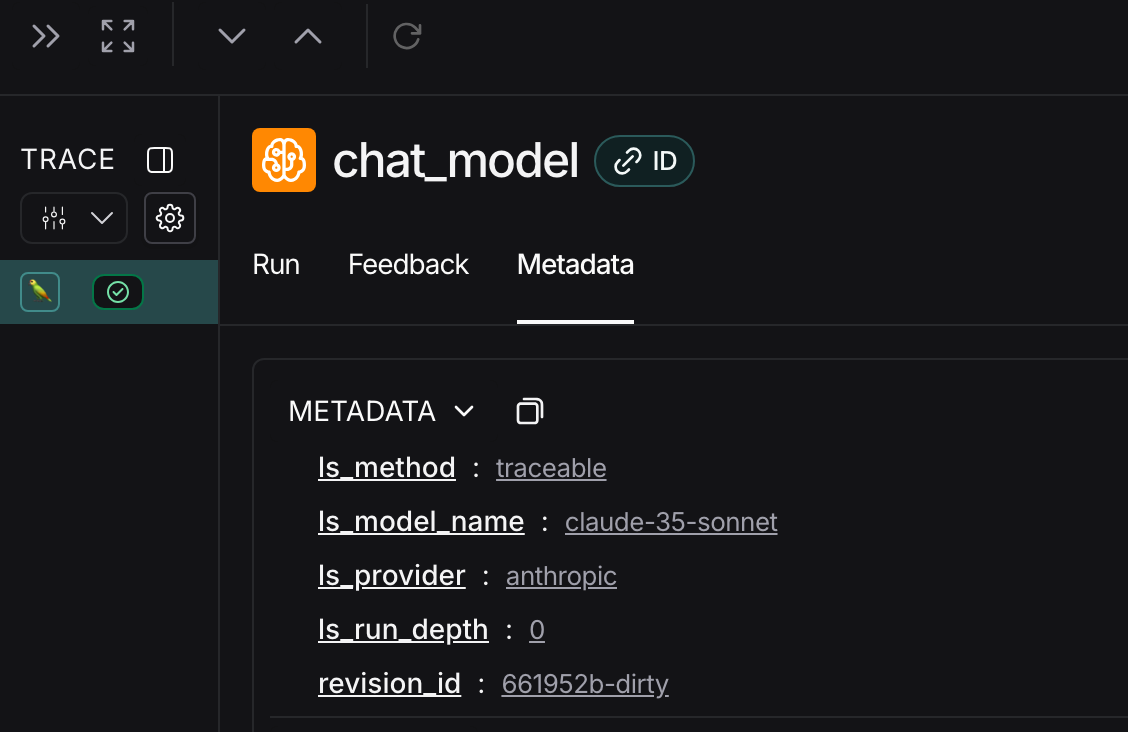

# SELF-EXERCISE:

In [8]:
from langsmith import traceable

inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "I'd like to book a table for two."},
]

output = {
  "message": {
    "role": "assistant",
    "content": "Sure, what time would you like to book the table for?"
  }
}

@traceable(
  run_type="llm",
  metadata={
    "ls_provider": "anthropic", 
    "ls_model_name": "claude-35-sonnet"
  }
)
def chat_model(messages: list):
  return output

chat_model(inputs)

{'message': {'role': 'assistant',
  'content': 'Sure, what time would you like to book the table for?'}}

In [9]:
from langsmith import traceable

inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "I'd like to book a table for two."},
]

output = {
    "role": "assistant",
    "content": "Sure, what time would you like to book the table for?"
}

@traceable(
  run_type="llm",
  metadata={
    "ls_provider": "anthropic", 
    "ls_model_name": "claude-35-sonnet"
  }
)

def chat_model(messages: list):
  return output

chat_model(inputs)

{'role': 'assistant',
 'content': 'Sure, what time would you like to book the table for?'}

In [10]:
from langsmith import traceable

inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "I'd like to book a table for two."},
]

output = ["assistant", "Sure, what time would you like to book the table for?"]

@traceable(
  run_type="llm",
  metadata={
    "ls_provider": "anthropic", 
    "ls_model_name": "claude-35-sonnet"
  }
)

def chat_model(messages: list):
  return output

chat_model(inputs)

['assistant', 'Sure, what time would you like to book the table for?']

### Handling Streaming LLM Runs

For streaming, you can "reduce" the outputs into the same format as the non-streaming version. This is currently only supported in Python.

In [5]:
def _reduce_chunks(chunks: list):
    all_text = "".join([chunk["choices"][0]["message"]["content"] for chunk in chunks])
    return {"choices": [{"message": {"content": all_text, "role": "assistant"}}]}

@traceable(
    run_type="llm",
    metadata={"ls_provider": "my_provider", "ls_model_name": "my_model"},
    # TODO: Add a reduce_fn
    reduce_fn=_reduce_chunks
)
def my_streaming_chat_model(messages: list):
    for chunk in ["Hello, " + messages[1]["content"]]:
        yield {
            "choices": [
                {
                    "message": {
                        "content": chunk,
                        "role": "assistant",
                    }
                }
            ]
        }

list(
    my_streaming_chat_model(
        [
            {"role": "system", "content": "You are a helpful assistant. Please greet the user."},
            {"role": "user", "content": "polly the parrot"},
        ],
    )
)

[{'choices': [{'message': {'content': 'Hello, polly the parrot',
     'role': 'assistant'}}]}]

### Retriever Runs + Documents

Many LLM applications require looking up documents from vector databases, knowledge graphs, or other types of indexes. Retriever traces are a way to log the documents that are retrieved by the retriever. LangSmith provides special rendering for retrieval steps in traces to make it easier to understand and diagnose retrieval issues. In order for retrieval steps to be rendered correctly, a few small steps need to be taken.

1. Annotate the retriever step with run_type="retriever".
2. Return a list of Python dictionaries or TypeScript objects from the retriever step. Each dictionary should contain the following keys:
    - page_content: The text of the document.
    - type: This should always be "Document".
    - metadata: A python dictionary or TypeScript object containing metadata about the document. This metadata will be displayed in the trace.

In [14]:
from langsmith import traceable

def _convert_docs(results):
  return [
      {
          "page_content": r,
          "type": "Document", # This is the wrong format! The key should be type
          "metadata": {"foo": "bar"}
      }
      for r in results
  ]

@traceable(
    # TODO: Add an run_type="retriever"
    run_type="retriever"
)
def retrieve_docs(query):
  # Retriever returning hardcoded dummy documents.
  # In production, this could be a real vector datatabase or other document index.
  contents = ["Document contents 1", "Document contents 2", "Document contents 3"]
  return _convert_docs(contents)

retrieve_docs("User query")

[{'page_content': 'Document contents 1',
  'type': 'Document',
  'metadata': {'foo': 'bar'}},
 {'page_content': 'Document contents 2',
  'type': 'Document',
  'metadata': {'foo': 'bar'}},
 {'page_content': 'Document contents 3',
  'type': 'Document',
  'metadata': {'foo': 'bar'}}]

__We ran this code once with the key as "doc_type" (which was the incorrect key) and once as "type" and also set the run_type as retriever. When we compare the traces we can see a difference in the output formats, whe we type the correct format the documents are formatted in a more organized way.__

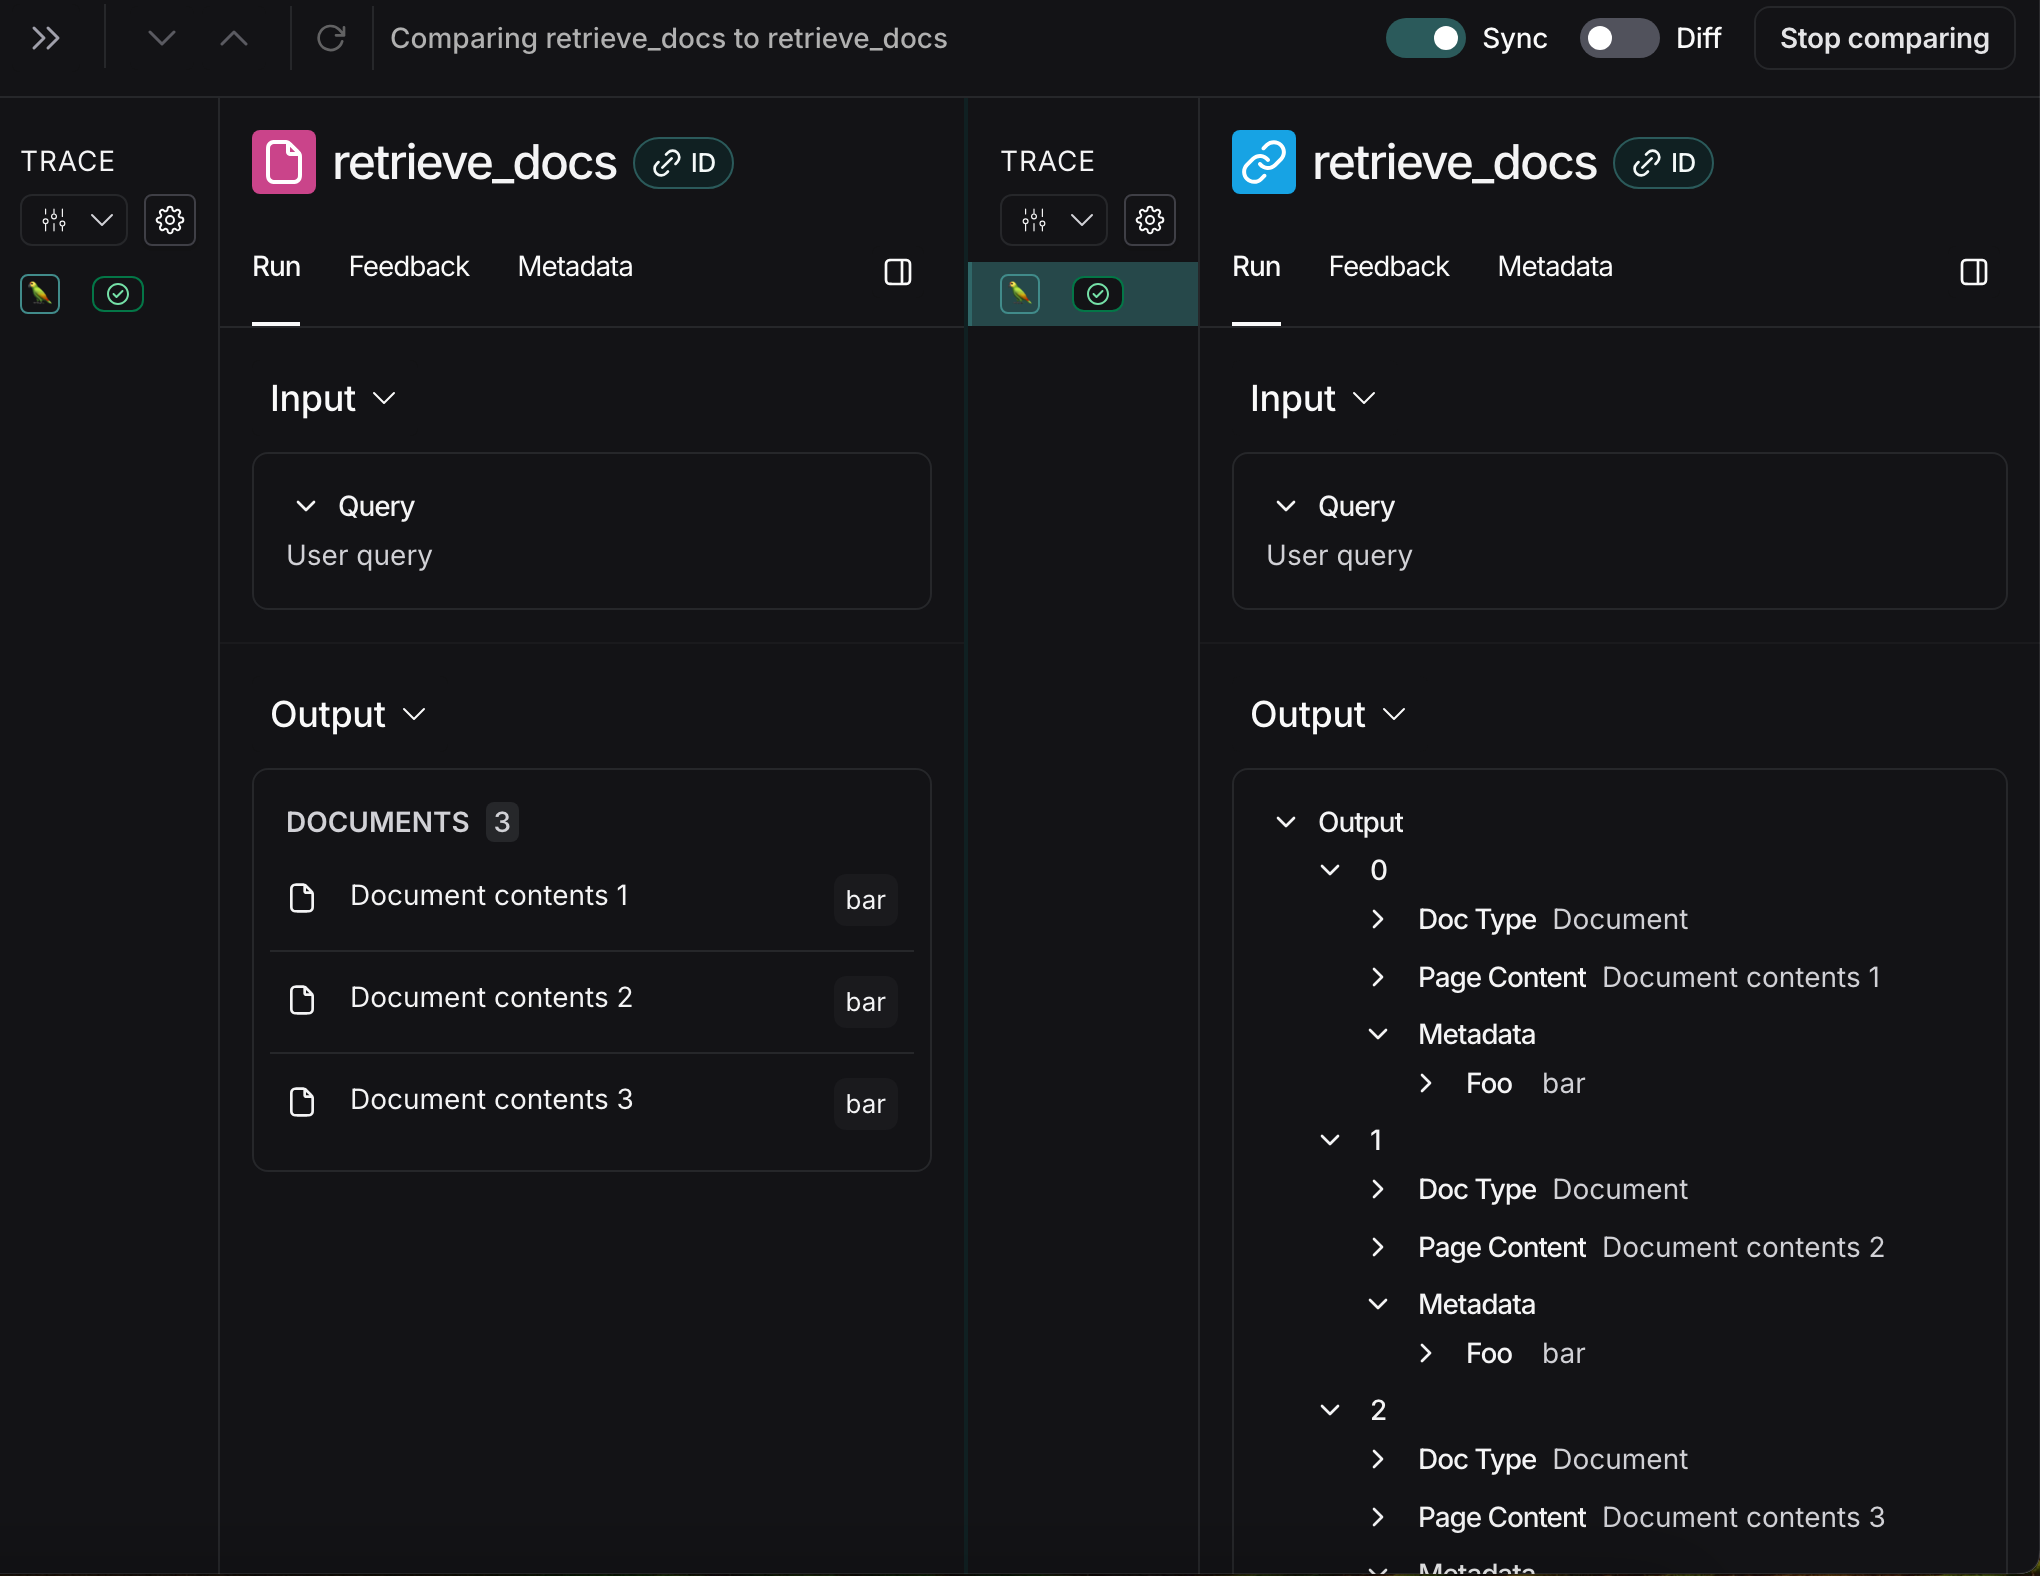

### Tool Calling

LangSmith has custom rendering for Tool Calls made by the model to make it clear when provided tools are being used.

In [7]:
from langsmith import traceable
from openai import OpenAI
from typing import List, Optional
import json

openai_client = OpenAI()

@traceable(
  # TODO: Add an run_type="tool"
  run_type="tool"
)
def get_current_temperature(location: str, unit: str):
    return 65 if unit == "Fahrenheit" else 17

@traceable(run_type="llm")
def call_openai(
    messages: List[dict], tools: Optional[List[dict]]
) -> str:
  return openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=messages,
    temperature=0,
    tools=tools
  )

@traceable(run_type="chain")
def ask_about_the_weather(inputs, tools):
  response = call_openai(inputs, tools)
  tool_call_args = json.loads(response.choices[0].message.tool_calls[0].function.arguments)
  location = tool_call_args["location"]
  unit = tool_call_args["unit"]
  tool_response_message = {
    "role": "tool",
    "content": json.dumps({
        "location": location,
        "unit": unit,
        "temperature": get_current_temperature(location, unit),
    }),
    "tool_call_id": response.choices[0].message.tool_calls[0].id
  }
  inputs.append(response.choices[0].message)
  inputs.append(tool_response_message)
  output = call_openai(inputs, None)
  return output

tools = [
    {
      "type": "function",
      "function": {
        "name": "get_current_temperature",
        "description": "Get the current temperature for a specific location",
        "parameters": {
          "type": "object",
          "properties": {
            "location": {
              "type": "string",
              "description": "The city and state, e.g., San Francisco, CA"
            },
            "unit": {
              "type": "string",
              "enum": ["Celsius", "Fahrenheit"],
              "description": "The temperature unit to use. Infer this from the user's location."
            }
          },
          "required": ["location", "unit"]
        }
      }
    }
]
inputs = [
  {"role": "system", "content": "You are a helpful assistant."},
  {"role": "user", "content": "What is the weather today in New York City?"},
]

ask_about_the_weather(inputs, tools)

ChatCompletion(id='chatcmpl-CMxQtZLtI9wEb0yakFo8iJAEvnLQR', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The current temperature in New York City is 65°F. If you need more detailed weather information, feel free to ask!', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1759587711, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_51db84afab', usage=CompletionUsage(completion_tokens=25, prompt_tokens=83, total_tokens=108, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

__The first llm call recognised that we have a tool named get_current_tempurature then the tool is called/invoked and then lastly we can see the tool message in the chat call history which provides the tools call output which helps generate the final llm output.__

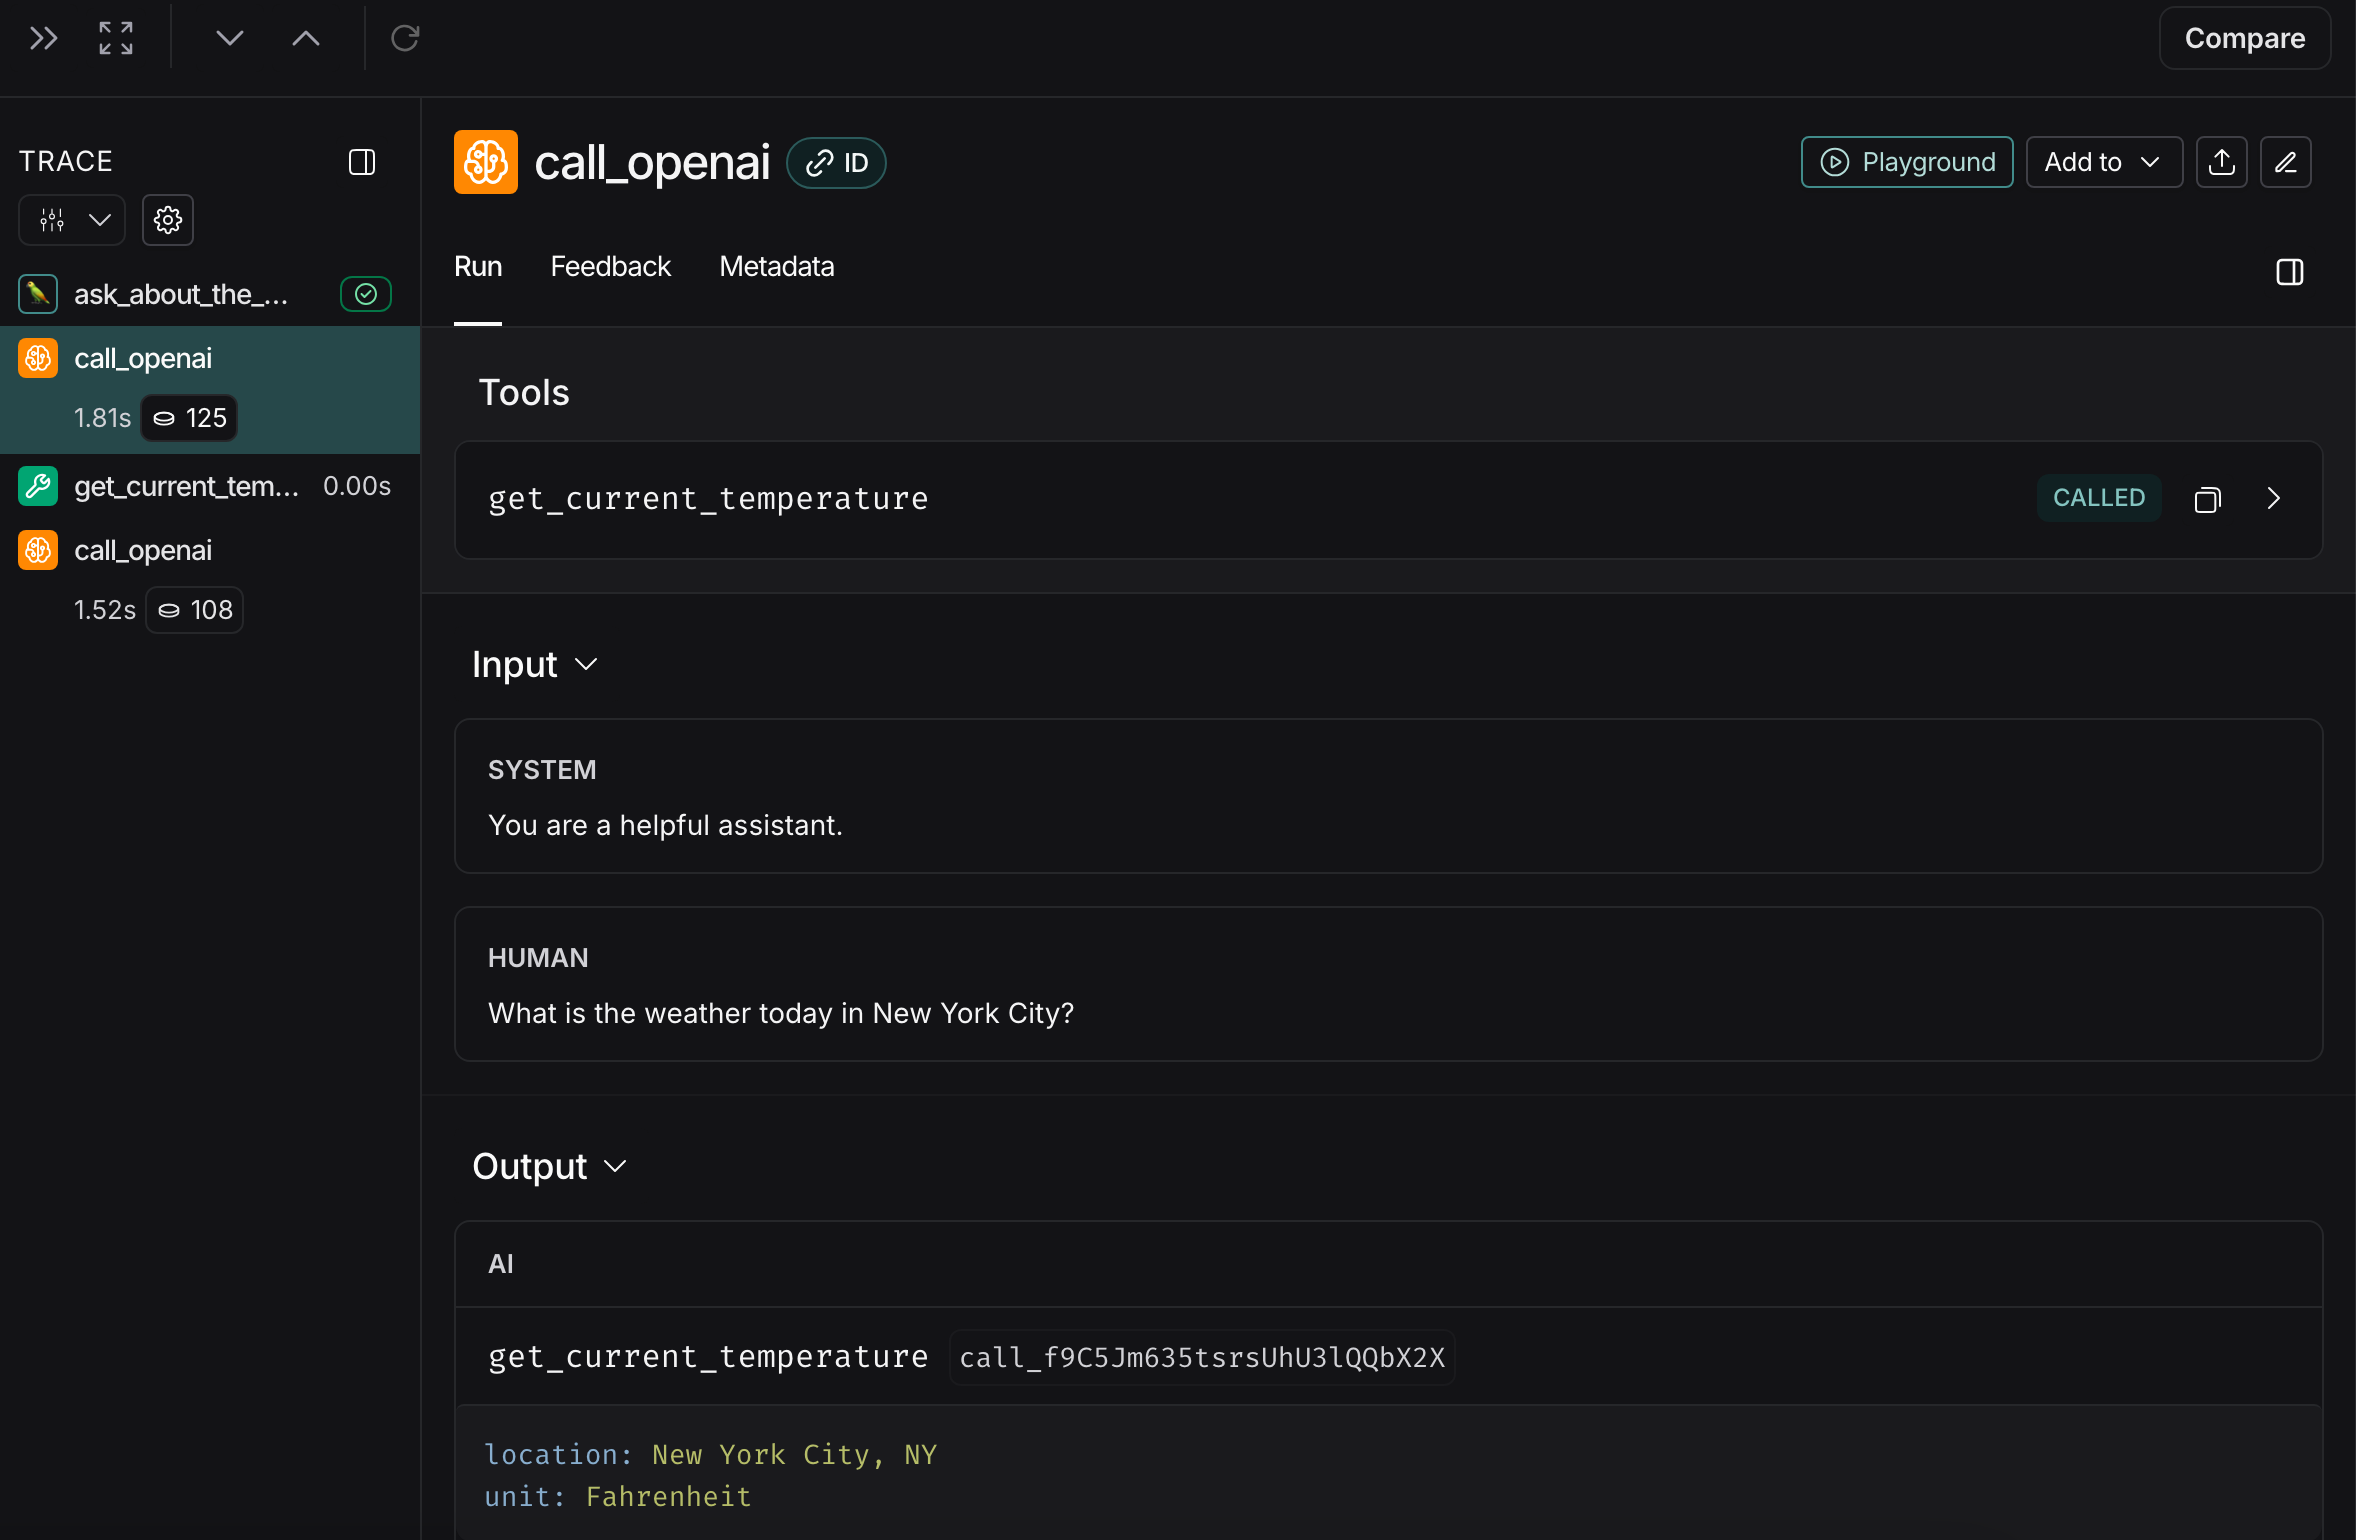
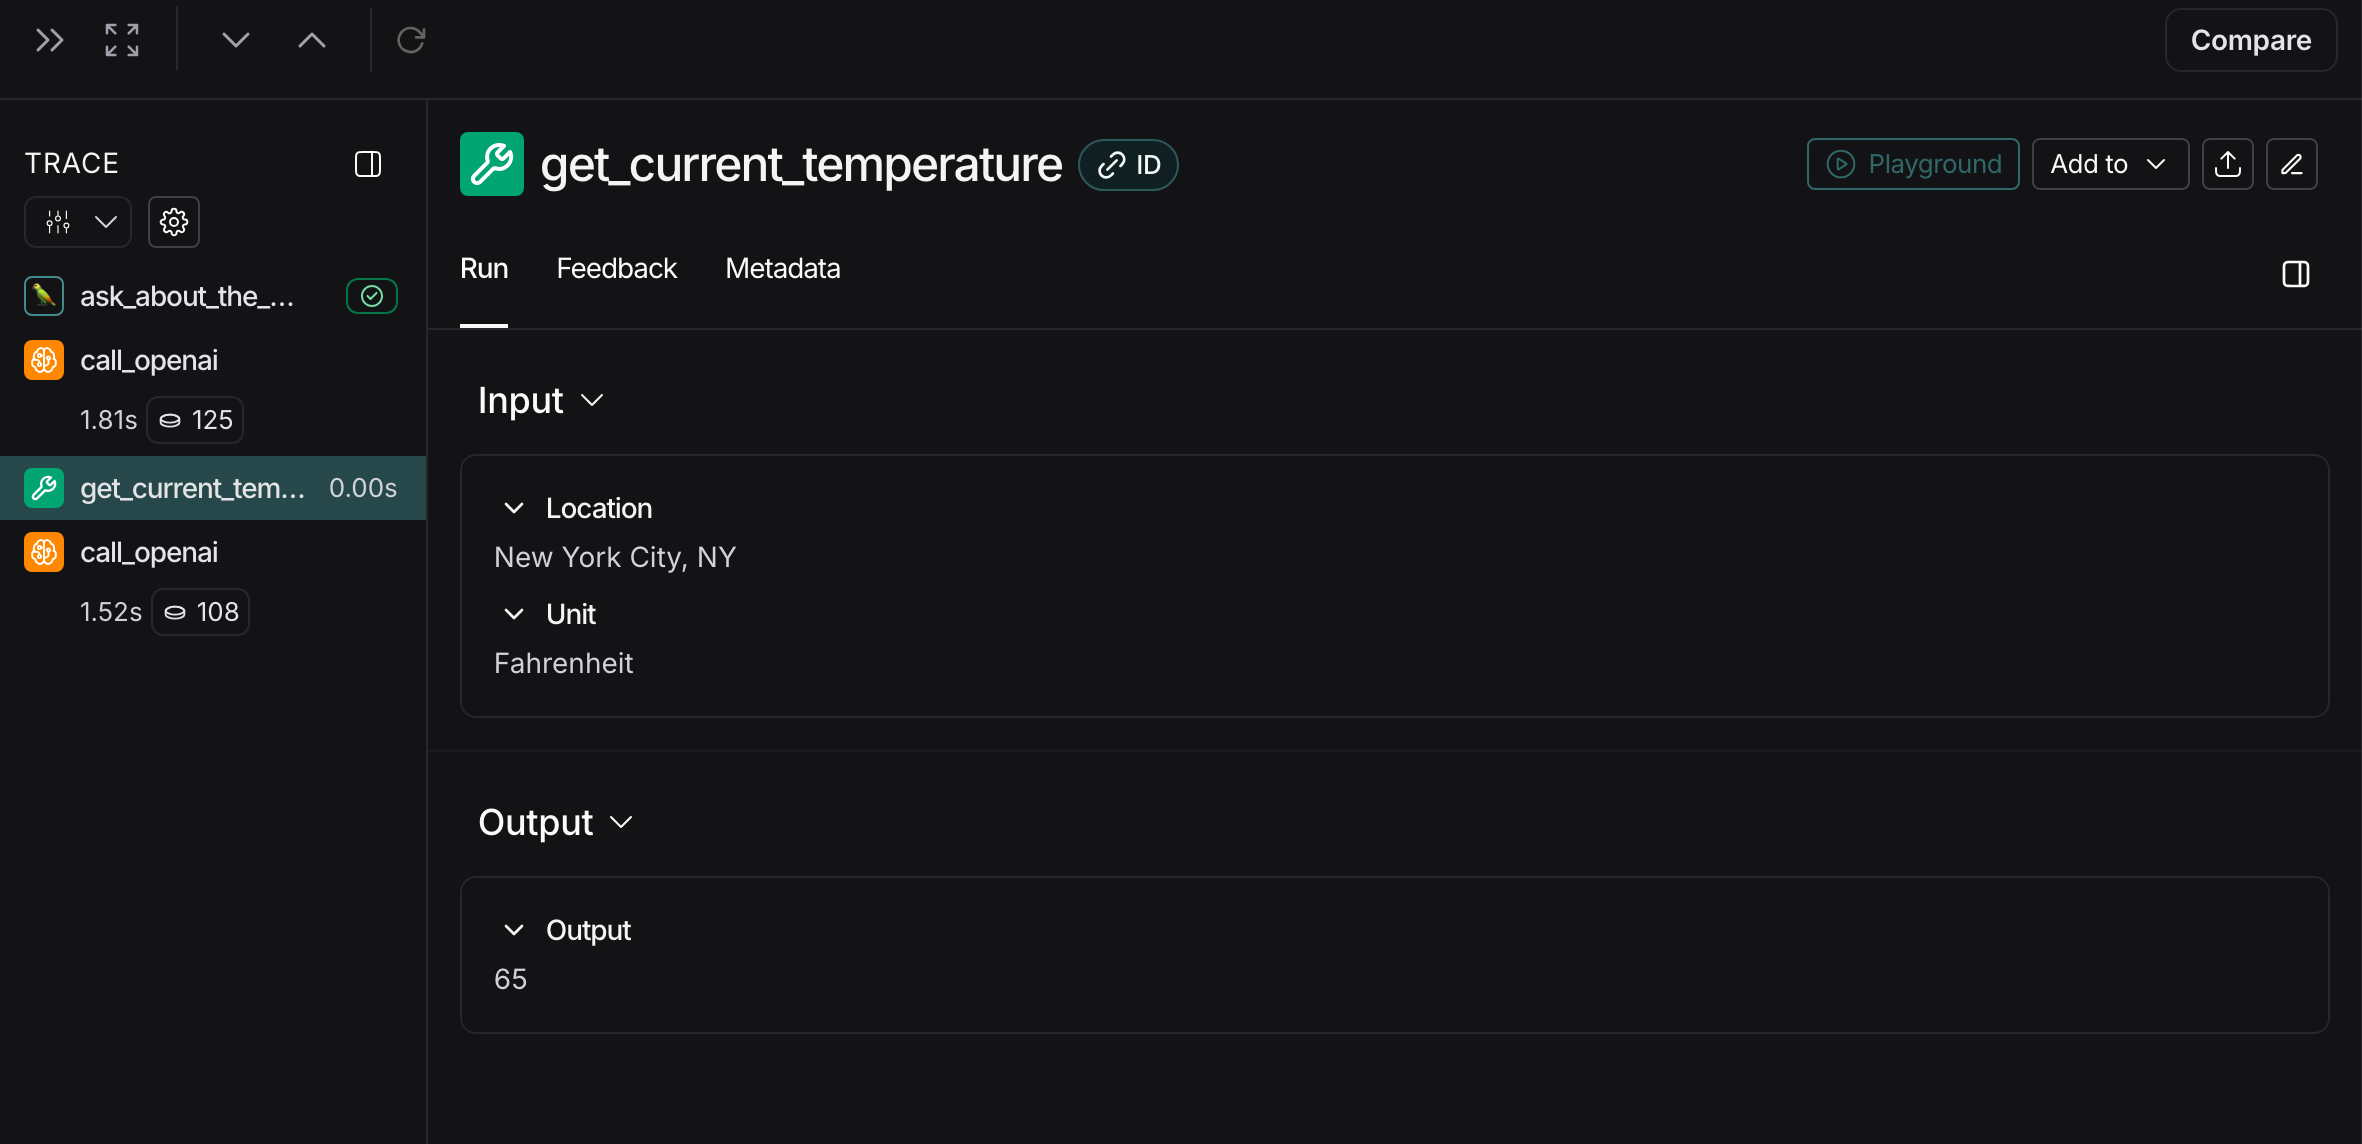
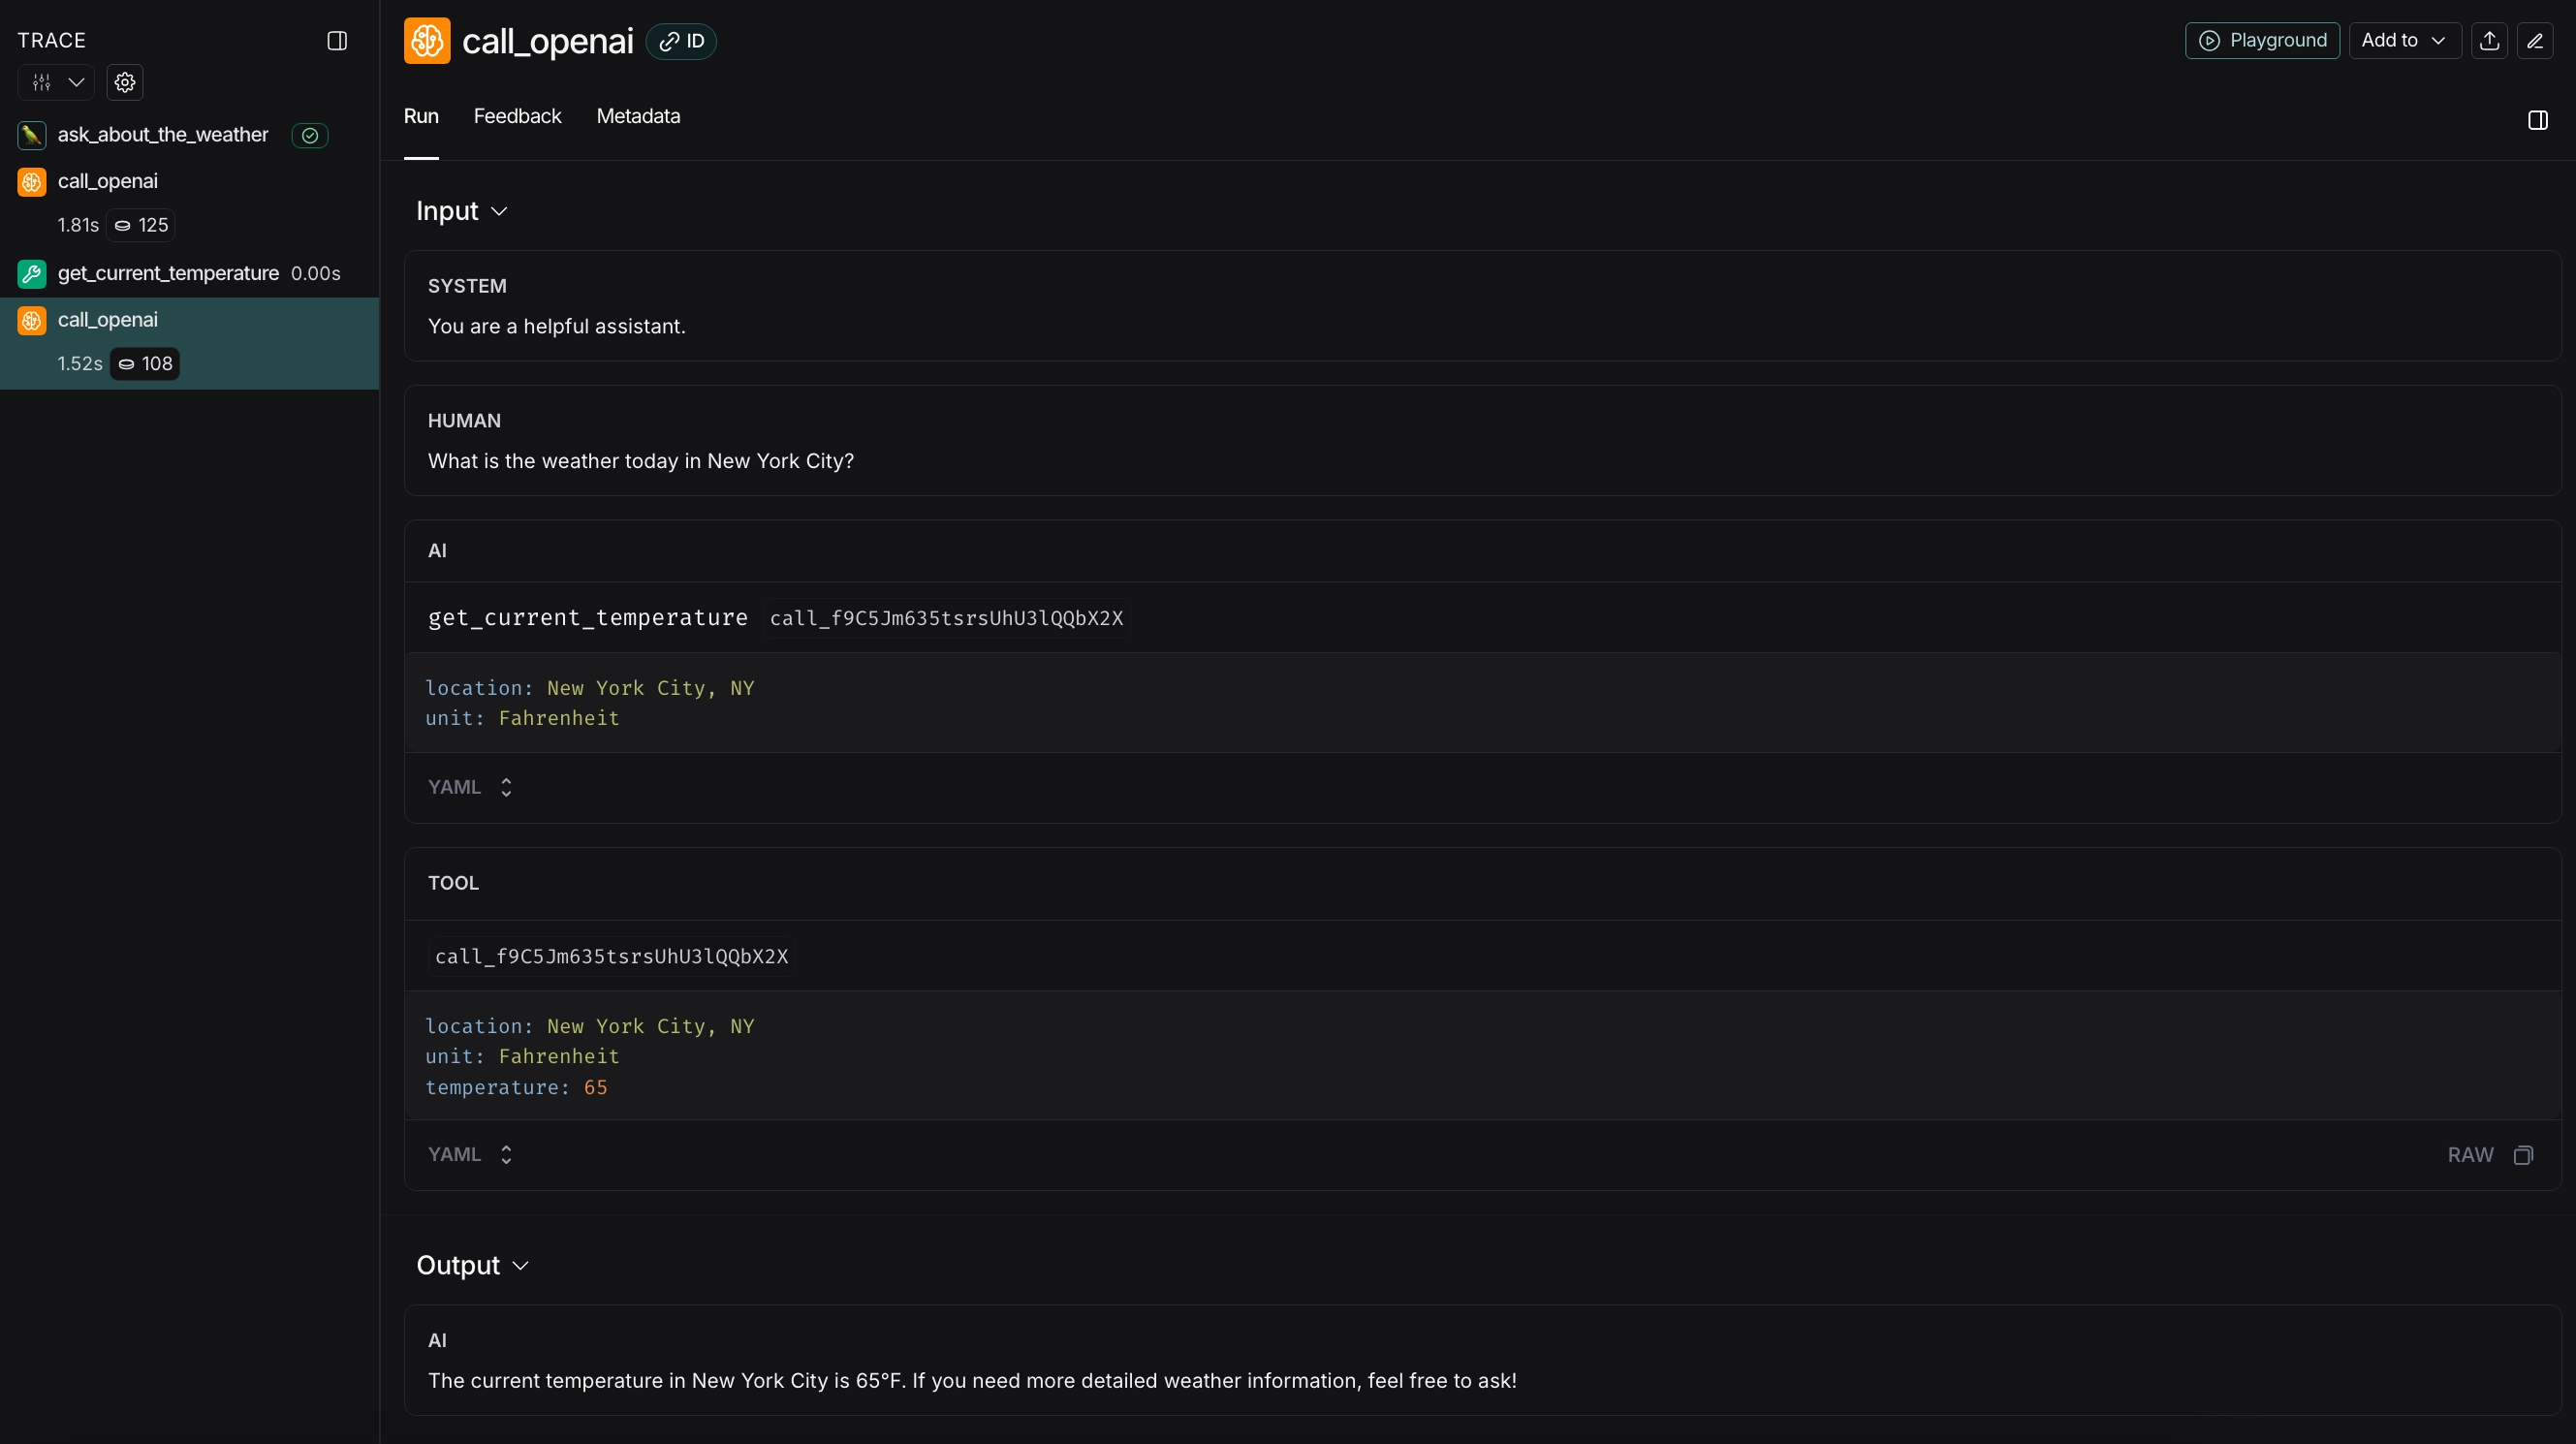

# SELF-EXERCISE:
__I made my own, new tool call, by defining "convert_currency"__


In [15]:
from langsmith import traceable
from openai import OpenAI
from typing import List, Optional
import json

openai_client = OpenAI()

@traceable(run_type="tool")
def convert_currency(amount: float, from_currency: str, to_currency: str):
    # Dummy conversion rates
    rates = {
        ("USD", "INR"): 83.0,
        ("INR", "USD"): 0.012,
    }
    rate = rates.get((from_currency, to_currency), 1.0)
    return round(amount * rate, 2)

@traceable(run_type="llm")
def call_openai(messages: List[dict], tools: Optional[List[dict]]) -> str:
    return openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0,
        tools=tools,
    )

@traceable(run_type="chain")
def ask_about_currency_conversion(inputs, tools):
    response = call_openai(inputs, tools)
    tool_call_args = json.loads(response.choices[0].message.tool_calls[0].function.arguments)

    amount = tool_call_args["amount"]
    from_currency = tool_call_args["from_currency"]
    to_currency = tool_call_args["to_currency"]

    tool_response_message = {
        "role": "tool",
        "content": json.dumps({
            "amount": amount,
            "from_currency": from_currency,
            "to_currency": to_currency,
            "converted_amount": convert_currency(amount, from_currency, to_currency),
        }),
        "tool_call_id": response.choices[0].message.tool_calls[0].id
    }

    inputs.append(response.choices[0].message)
    inputs.append(tool_response_message)

    output = call_openai(inputs, None)
    return output

tools = [
    {
        "type": "function",
        "function": {
            "name": "convert_currency",
            "description": "Convert currency from one type to another",
            "parameters": {
                "type": "object",
                "properties": {
                    "amount": {
                        "type": "number",
                        "description": "The amount of money to convert"
                    },
                    "from_currency": {
                        "type": "string",
                        "description": "The currency to convert from (e.g., USD)"
                    },
                    "to_currency": {
                        "type": "string",
                        "description": "The currency to convert to (e.g., INR)"
                    }
                },
                "required": ["amount", "from_currency", "to_currency"]
            }
        }
    }
]

inputs = [
    {"role": "system", "content": "You are a financial assistant."},
    {"role": "user", "content": "Can you convert 100 USD to INR?"},
]

ask_about_currency_conversion(inputs, tools)


ChatCompletion(id='chatcmpl-CMzTSrgJxZpTmg6xkdSGgcUJnTNjG', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="100 USD is approximately 8300 INR. Please note that exchange rates can fluctuate, so it's a good idea to check for the most current rate if you're planning a transaction.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1759595558, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_560af6e559', usage=CompletionUsage(completion_tokens=35, prompt_tokens=90, total_tokens=125, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

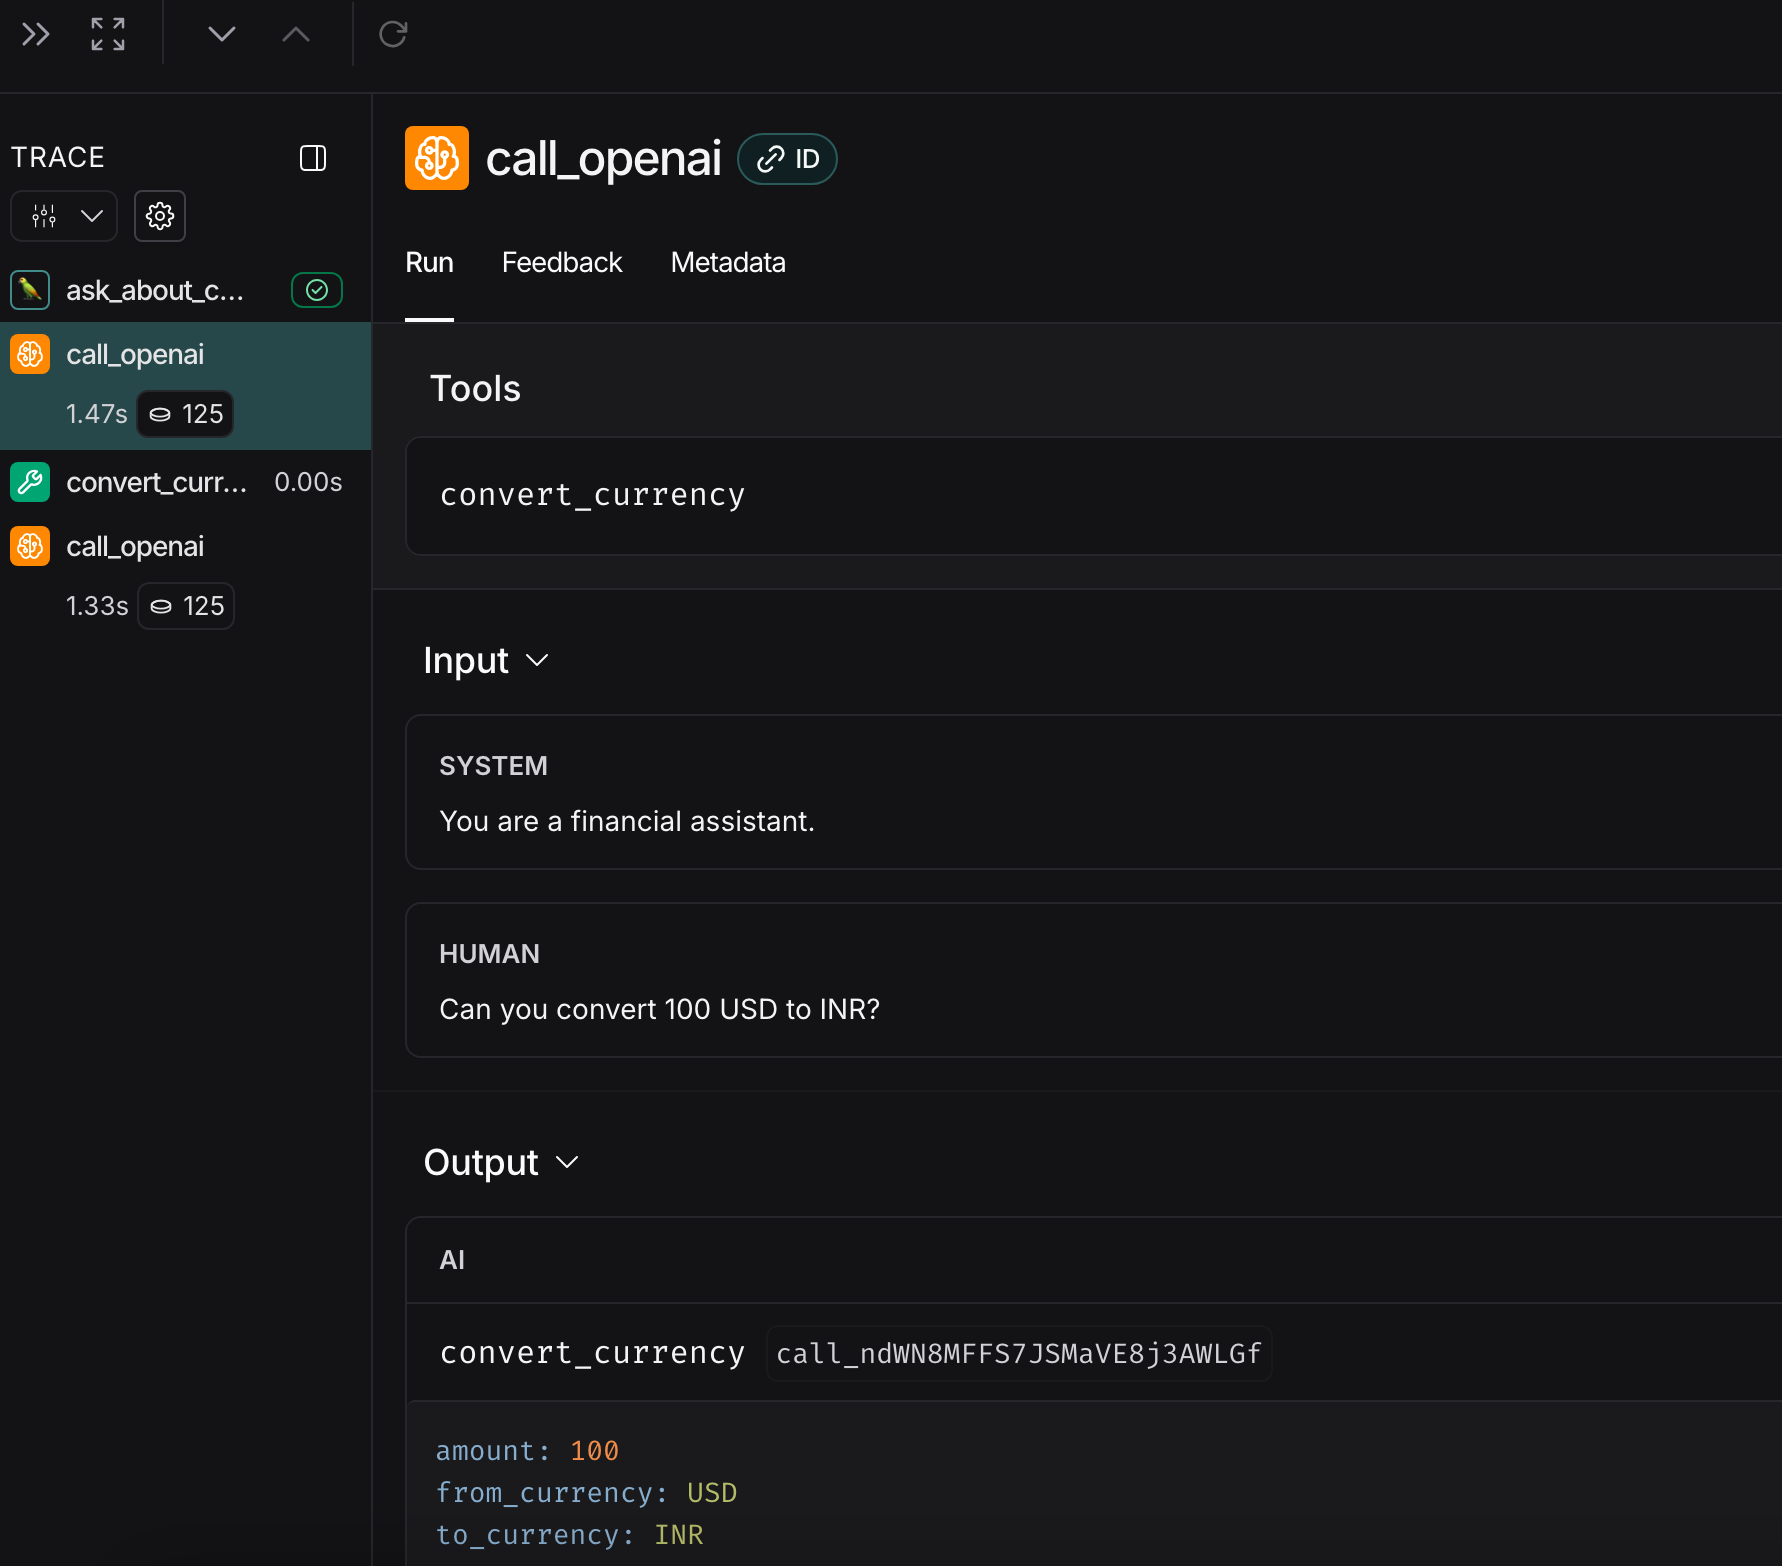
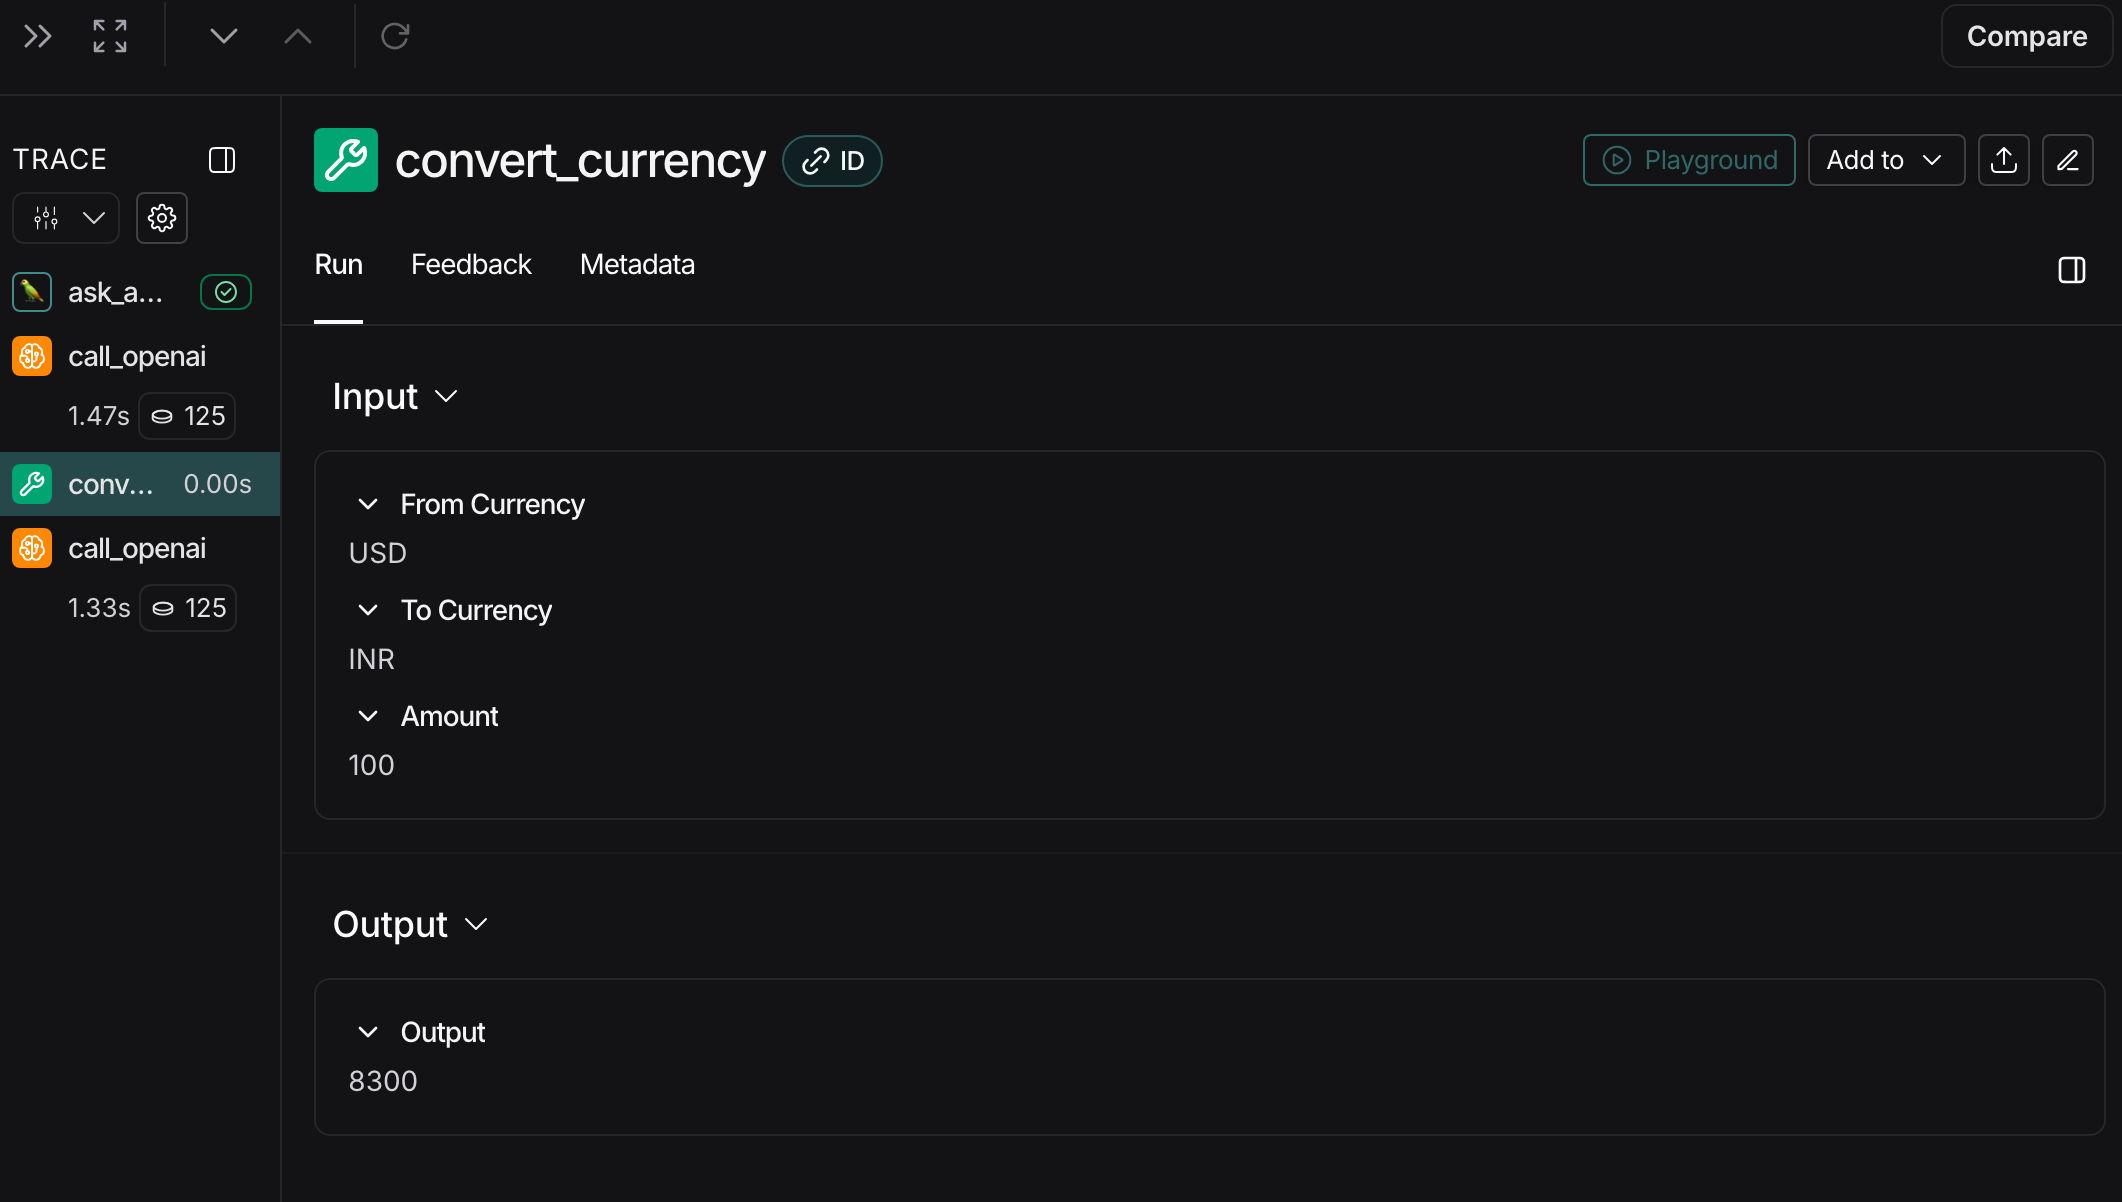
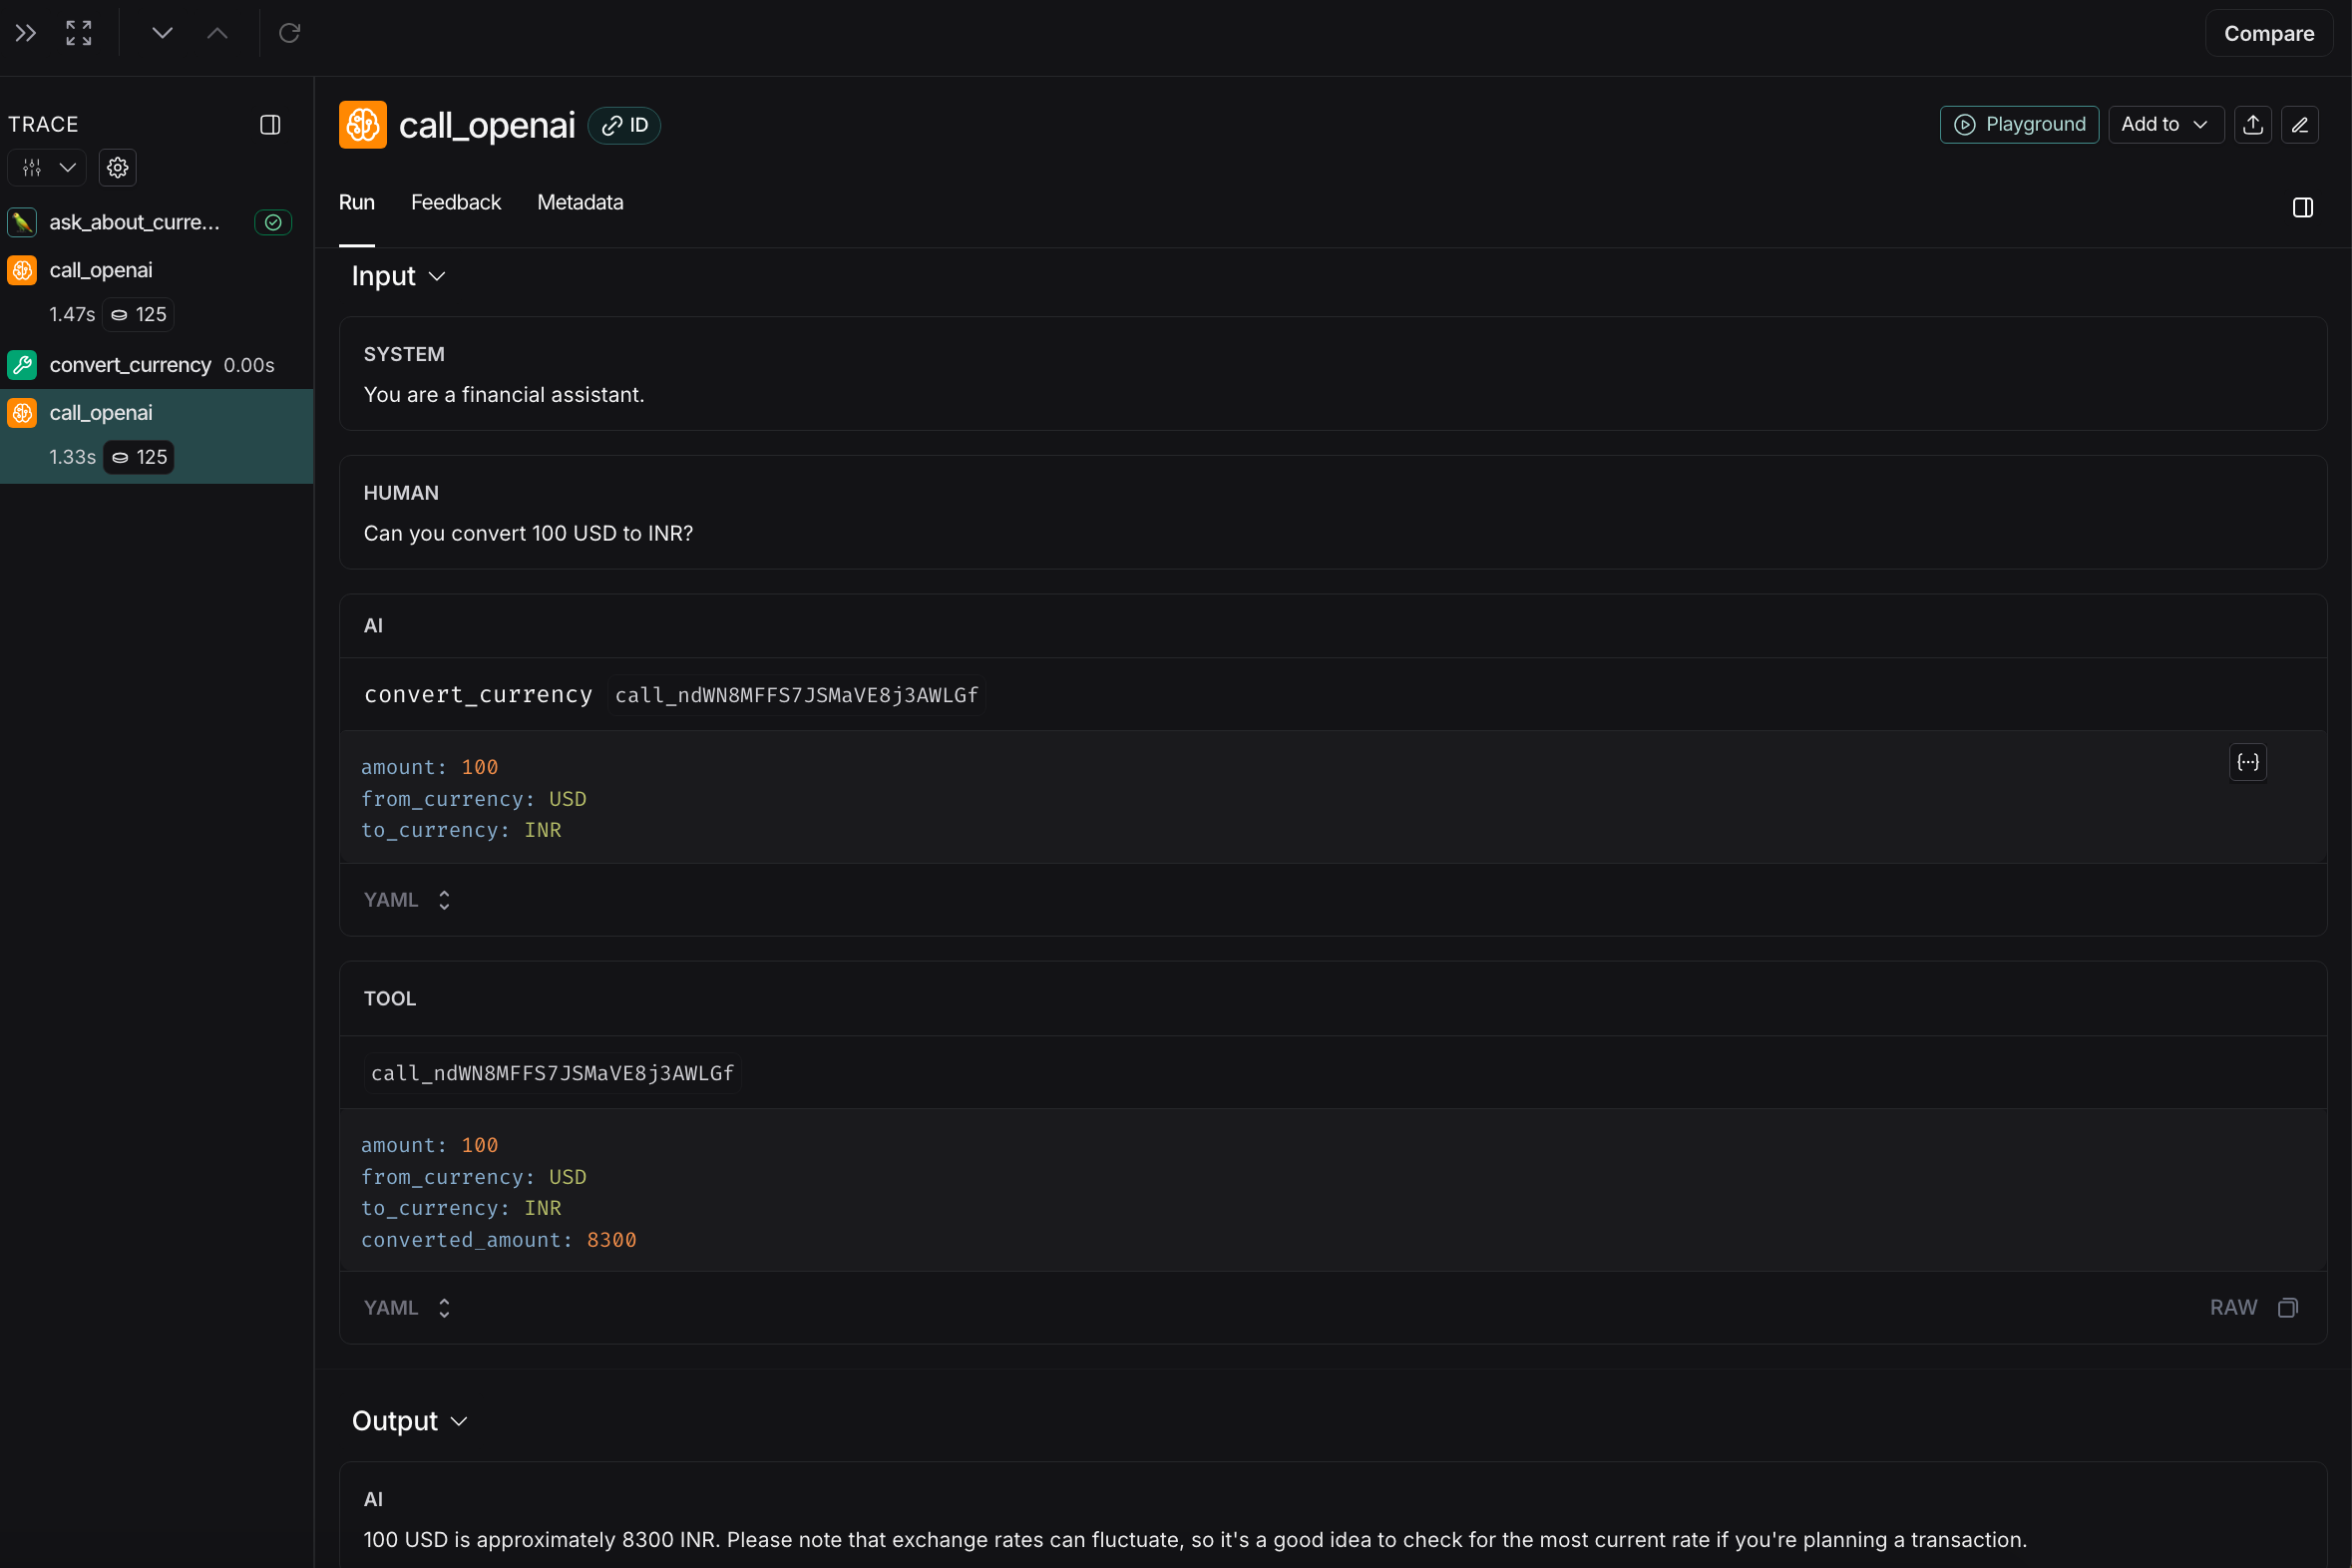